## Read Data

We will use closing price data for Apple (AAPL) stock. You can use your data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from pandas import DataFrame
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [58]:
# use your own data
poll = 'NO2'
NaN = np.nan
df = pd.read_csv('./AirPollutionSeoul/Measurement_summary.csv', index_col=['Date'])
df = df[(df[['Address']] == "19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republic of Korea").all(1)]
df.index = pd.to_datetime(df.index)
df = df.at_time('14:00')
df.index = df.index.normalize()
df = df[['PM10', 'O3', 'SO2', 'NO2', 'CO']]
df[df < 0] = NaN
new_date_range = pd.date_range(start="2017-01-01", end="2019-12-31", freq="D")
df = df.reindex(new_date_range, fill_value=NaN)
df = df.interpolate()
data = df[poll]

## LSTM Implementation

### Process Data

We will create a model that predicts the next day's closing price through the 4-day closing price of Apple stock. For this, the following pre-processing is required.

In [59]:
def sliding_windows(data, seq_length, delay, step):
    x = []
    y = []

    for i in range(len(data)-seq_length-delay-step):
        _x = data[i:(i+seq_length):step]
        _y = data[i+seq_length+delay+step]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [61]:
# min-max scale
sc = MinMaxScaler()
training_data = sc.fit_transform(data.values.reshape(-1, 1))


# using previous 4 days
seq_length = 168
delay = 24
step = 24

x, y = sliding_windows(training_data, seq_length, delay, step)


In [62]:
x

array([[[0.69620253],
        [0.48101266],
        [0.16455696],
        ...,
        [0.39240506],
        [0.36708861],
        [0.17721519]],

       [[0.44303797],
        [0.84810127],
        [0.37974684],
        ...,
        [0.41772152],
        [0.55696203],
        [0.13924051]],

       [[0.56962025],
        [0.16455696],
        [0.15189873],
        ...,
        [0.16455696],
        [0.40506329],
        [0.30379747]],

       ...,

       [[0.2278481 ],
        [0.26582278],
        [0.20253165],
        ...,
        [0.17721519],
        [0.2278481 ],
        [0.18987342]],

       [[0.2278481 ],
        [0.2278481 ],
        [0.27848101],
        ...,
        [0.17721519],
        [0.26582278],
        [0.13924051]],

       [[0.30379747],
        [0.13924051],
        [0.50632911],
        ...,
        [0.36708861],
        [0.24050633],
        [0.17721519]]])

<img src="https://trello.com/1/cards/637d5b489ff5ac008a2ad489/attachments/637d6ba532d829019debb8de/download/image.png" width=700>

As shown in the figure above, while sliding the window, you need to connect the data of the past 4 days and the future data.

Then, set an appropriate ratio as shown below to separate the train/test dataset.

In [63]:
split_ratio = 0.67
train_size = int(len(y) * split_ratio)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

### Define Model and Settings

To use the LSTM network, we need to set the dimensions and other parameters that fit the data we have prepared. You can easily understand through the picture below.

In [64]:
input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

<img src="https://trello.com/1/cards/637d5b489ff5ac008a2ad489/attachments/637d6bbcea5f9800374e23c5/download/image.png" width=700>

In order to learn the parameters of the model, a criterion is needed to define the difference between the predicted value and the actual value of the model. You can set which loss metric to use through `criterion`.

Also, an `optimizer` is needed to adjust the parameters to reduce the loss. Here, <a href="#References" data-toc-modified-id="References-3"><span class="toc-item-num"></span>Adam</a> optimizer is used.

### Model Training

By setting the epoch, we can train the model as follows.

In [72]:
# Loss and Optimizer Setting
criterion = torch.nn.MSELoss()    # mean-squared error for regression

learning_rate = 0.0001
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# You can use other Optimizers
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
num_epochs = 500

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.03057
Epoch: 50, loss: 0.03057
Epoch: 100, loss: 0.03057
Epoch: 150, loss: 0.03057
Epoch: 200, loss: 0.03057
Epoch: 250, loss: 0.03057
Epoch: 300, loss: 0.03057
Epoch: 350, loss: 0.03057
Epoch: 400, loss: 0.03057
Epoch: 450, loss: 0.03057


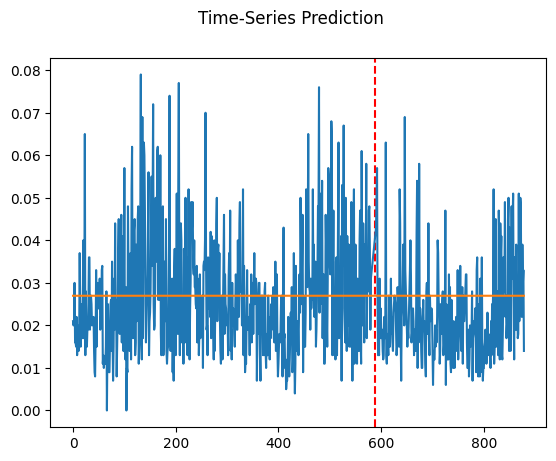

In [74]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.axvline(x=len(dataX) * split_ratio, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

The predicted values ​​of the model do not explain the actual values ​​well. 

1.   항목 추가
2.   항목 추가

So, let's move on to further training.

## References

Hochreiter, S., & Schmidhuber, J. (1997). [Long short-term memory](http://www.bioinf.jku.at/publications/older/2604.pdf). Neural computation, 9(8), 1735–1780. <br>
Kingma, D.P., & Ba, J. (2015). [Adam: A Method for Stochastic Optimization](https://arxiv.org/pdf/1412.6980.pdf). CoRR, abs/1412.6980. <br>
Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2021). [Dive into Deep Learning](https://d2l.ai/). ArXiv Preprint ArXiv:2106.11342.